In [1]:
import numpy as np
import pandas as pd

import torch
import matplotlib.pyplot as plt
from torch import nn
from torch.autograd import Variable

import torchvision
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import confusion_matrix

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [3]:
# download from
# https://www.kaggle.com/zalando-research/fashionmnist
train_csv = pd.read_csv('./dataset/fashion-mnist_train.csv')
test_csv = pd.read_csv('./dataset/fashion-mnist_test.csv') 

In [4]:
class FashionDataset(Dataset):
    """
        user fashion mnist defined dataset (loading from csv)
    """   
    def __init__(self, data, transform=None):
        self.dataset = list(data.values)
        self.transform = transform
        
        labels = []
        images = []
        
        # in excel row 0 is label, rest are pixels
        for row in self.dataset:
            labels.append(row[0])
            images.append(row[1:])
        
        # do not copy data (hence use np.asarray)
        # and reshape images to array of a scale of 28x28 pixels, 1 color channel
        self.labels = np.asarray(labels)
        self.images = np.asarray(images).reshape(-1, 28, 28, 1).astype('float32')
        
    def __getitem__(self, index):
        label = self.labels[index]
        image = self.images[index]
        
        if self.transform is not None:
            image = self.transform(image)
            
        return image, label
    
    def __len__(self):
        return len(self.labels) 

In [5]:
# define train and test dataset
train_set = FashionDataset(train_csv, transforms.Compose([transforms.ToTensor()]))
test_set = FashionDataset(test_csv, transforms.Compose([transforms.ToTensor()]))

# init data loader
train_loader = DataLoader(train_set, batch_size=100)
test_loader = DataLoader(test_set, batch_size=100)

In [6]:
class_labels = ['T-Shirt', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle Boot']
# class_labels = {i: v for i, v in enumerate(class_labels)}

def class_label(label):
    return class_labels[label.item() if type(label) == torch.Tensor else label]

In [7]:
# play with data
next(iter(train_loader))[0].size()

torch.Size([100, 1, 28, 28])

In [8]:
len(train_set)

37916

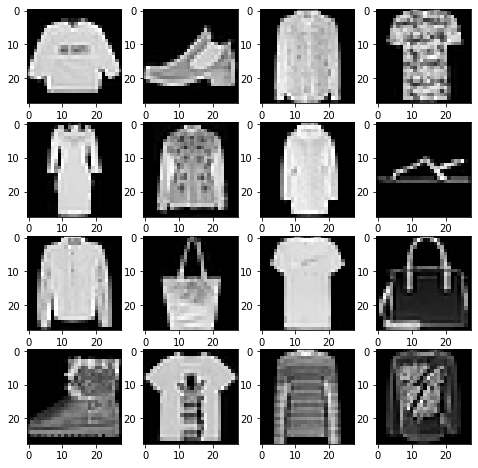

In [9]:
 train_set_iter = iter(train_set)

rows, columns = 4, 4
fig, ax = plt.subplots(nrows=rows, ncols=columns, figsize=(8, 8))

for i, axis in enumerate(ax.flat):
    image, label = next(train_set_iter)
    axis.imshow(image.squeeze(), cmap='gray')
    
plt.show()

# Building a CNN

- Make a model class (FashionCNN in our case)
    -It inherit nn.Module class that is a super class for all the neural networks in Pytorch.

- Our Neural Net has following layers:

    - Two Sequential layers each consists of following layers-
        - Convolution layer that has kernel size of 3 * 3, padding = 1 (zero_padding) in 1st layer and padding = 0 in second one. Stride of 1 in both layer.
        - Batch Normalization layer.
        - Acitvation function: ReLU.
        - Max Pooling layer with kernel size of 2 * 2 and stride 2.
            - Flatten out the output for dense layer(a.k.a. fully connected layer).
            - 3 Fully connected layer with different in/out features.
            - 1 Dropout layer that has class probability p = 0.25.
        - All the functionaltiy is given in forward method that defines the forward pass of CNN.
        - Our input image is changing in a following way:
            - First Convulation layer : input: 28 * 28 * 3, output: 28 * 28 * 32
            - First Max Pooling layer : input: 28 * 28 * 32, output: 14 * 14 * 32
            - Second Conv layer : input : 14 * 14 * 32, output: 12 * 12 * 64
            - Second Max Pooling layer : 12 * 12 * 64, output: 6 * 6 * 64
    - Final fully connected layer has 10 output features for 10 types of clothes.


In [12]:
class FashionCNN(nn.Module):
    """
    convolutional neural network for training
    """
    
    def __init__(self):
        super(FashionCNN, self).__init__()
        
        self.layer1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        
        self.layer2 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        
        self.fc1 = nn.Linear(in_features=6*6*64, out_features=600)
        self.drop = nn.Dropout(0.25)
        self.fc2 = nn.Linear(in_features=600, out_features=120)
        self.fc3= nn.Linear(in_features=120, out_features=10)
        
    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        x = self.drop(x)
        x = self.fc2(x)
        x = self.fc3(x)
        
        return x

In [13]:
model = FashionCNN().to(device)
error = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

model

FashionCNN(
  (layer1): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc1): Linear(in_features=2304, out_features=600, bias=True)
  (drop): Dropout(p=0.25, inplace=False)
  (fc2): Linear(in_features=600, out_features=120, bias=True)
  (fc3): Linear(in_features=120, out_features=10, bias=True)
)

In [16]:
num_epochs = 5
count = 0
# Lists for visualization of loss and accuracy 
loss_list = []
iteration_list = []
accuracy_list = []

# Lists for knowing classwise accuracy
predictions_list = []
labels_list = []

for epoch in range(num_epochs):
    for images, labels in train_loader:
        # Transfering images and labels to GPU if available
        images, labels = images.to(device), labels.to(device)
    
        train = Variable(images.view(100, 1, 28, 28))
        labels = Variable(labels)
        
        # Forward pass 
        outputs = model(train)
        loss = error(outputs, labels)
        
        # Initializing a gradient as 0 so there is no mixing of gradient among the batches
        optimizer.zero_grad()
        
        #Propagating the error backward
        loss.backward()
        
        # Optimizing the parameters
        optimizer.step()
    
        count += 1
    
        # Testing the model
    
        if not (count % 50):    # It's same as "if count % 50 == 0"
            total = 0
            correct = 0
     
            for images, labels in test_loader:
                images, labels = images.to(device), labels.to(device)
                labels_list.append(labels)
            
                test = Variable(images.view(100, 1, 28, 28))
            
                outputs = model(test)
            
                predictions = torch.max(outputs, 1)[1].to(device)
                predictions_list.append(predictions)
                correct += (predictions == labels).sum()
            
                total += len(labels)
            
            accuracy = correct * 100 / total
            loss_list.append(loss.data)
            iteration_list.append(count)
            accuracy_list.append(accuracy)
        
        if not (count % 500):
            print("Iteration: {}, Loss: {}, Accuracy: {}%".format(count, loss.data, accuracy))

RuntimeError: expected scalar type Long but found Double